In [1]:
'''
This script demonstrates how to build a variational autoencoder via Keras to decompose 
high-dimensional wafermaps into low-dimensional latent representations, then cluster them.
Main reference: "Auto-Encoding Variational Bayes", https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Activation
from keras.layers.normalization import *
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist


import sys
sys.path.append('../src')

from data_utils import *
from plot_utils import *

# sample initialization
batch_size = 100
original_dim = 128*128
latent_dim = 3
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(128)(x)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(64)(h)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(32)(h)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(32, activation='relu')
decoder_h2 = Dense(64, activation='relu')
decoder_h3 = Dense(128, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
h_decoded = decoder_h3(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

loss_log = []

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

x_train = load_wafers('clean2_train')
x_train = (x_train + 1) / 2
#x_train = x_train.reshape(x_train.shape[0], 128, 128)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


(5808, 196, 80)


In [2]:
print(x_train.shape)

(5808, 16384)


In [4]:
vae.fit(x_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size)

Epoch 1/20
5808/5808 [==============================] - 4s 729us/step - loss: 10207.9588
Epoch 2/20
5808/5808 [==============================] - 6s 991us/step - loss: 10207.6982
Epoch 3/20
5808/5808 [==============================] - 10s 2ms/step - loss: 10202.8701
Epoch 4/20
5808/5808 [==============================] - 7s 1ms/step - loss: 10197.7484
Epoch 5/20
5808/5808 [==============================] - 11s 2ms/step - loss: 10192.5643
Epoch 6/20
5808/5808 [==============================] - 9s 2ms/step - loss: 10185.0280
Epoch 7/20
5808/5808 [==============================] - 10s 2ms/step - loss: 10186.1568
Epoch 8/20
5808/5808 [==============================] - 10s 2ms/step - loss: 10175.5836
Epoch 9/20
5808/5808 [==============================] - 7s 1ms/step - loss: 10175.3824
Epoch 10/20
5808/5808 [==============================] - 6s 1ms/step - loss: 10166.5785
Epoch 11/20
5808/5808 [==============================] - 8s 1ms/step - loss: 10169.3103
Epoch 12/20
5808/5808 [==========

In [5]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering

In [6]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

x_data = load_wafers('clean2_test')
x_data = (x_data + 1) / 2
#x_train = x_train.reshape(x_train.shape[0], 128, 128)
x_data = x_data.reshape((len(x_data), np.prod(x_data.shape[1:])))

# display a 2D plot of the digit classes in the latent space
x_encoded = encoder.predict(x_data, batch_size=batch_size)

np.savetxt("VAE-product2_dim3_test.csv", x_encoded, delimiter=",")

(1800, 196, 80)


In [7]:
from sklearn import metrics
from sklearn.cluster import KMeans

for k in [4,6,8,10,12,14,16,18,20]:
    kmeans = KMeans(k)
    kmeans.fit(x_encoded)

    print(
        k,
        metrics.silhouette_score(x_encoded, kmeans.labels_),
        metrics.calinski_harabaz_score(x_encoded, kmeans.labels_)
    )

4 0.5354973 2415.119519607149
6 0.5013183 2704.837398789034
8 0.48856634 3205.070780414943
10 0.46867627 3470.0358549093708
12 0.49113882 3694.843414448535
14 0.49210694 3887.410277007196
16 0.45808014 3879.9766693554175
18 0.4553228 3810.485453739646
20 0.4364702 3822.4250723539512


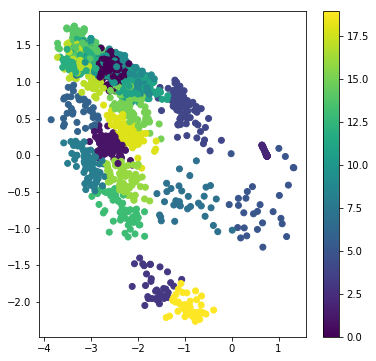

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(x_encoded[:, 0], x_encoded[:, 1], c=kmeans.labels_)
plt.colorbar()
plt.savefig('result_vae.pdf')
plt.show()

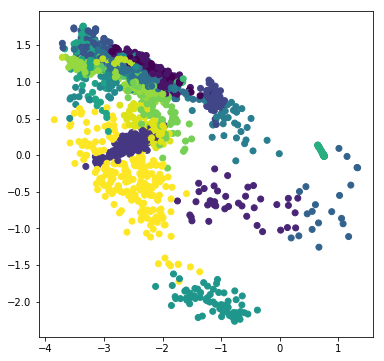

In [15]:
from gmm_mml import GmmMml

clf=GmmMml(8)
clf.fit(x_encoded)
labels = clf.predict(x_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_encoded[:, 0], x_encoded[:, 1], c=labels)
plt.colorbar()
plt.show()

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5).fit_transform(x_train)
for k in [4,6,8,10,12,14,16,18,20]:
    kmeans = KMeans(k)
    kmeans.fit(pca)

    print(
        k,
        metrics.silhouette_score(pca, kmeans.labels_)
    )

4 0.36757785
6 0.2841711
8 0.27613297
10 0.27784055
12 0.28507614
14 0.27071297
16 0.27190647
18 0.2689941
20 0.26672223


In [17]:
from sklearn.decomposition import NMF
from sklearn import metrics
from sklearn.cluster import KMeans

nmf = NMF(n_components=5).fit_transform(x_train)
for k in [4,6,8,10,12,14,16,18,20]:
    clust = AgglomerativeClustering(k)
    clust.fit(nmf)

    print(
        k,
        metrics.silhouette_score(nmf, clust.labels_)
    )

4 0.2595702032607219
6 0.2770277634635757
8 0.2515031897023453
10 0.2597189218674484
12 0.2670693742219586
14 0.26057352930455435
16 0.26947158777549896
18 0.25562996838021906
20 0.24856146350195282


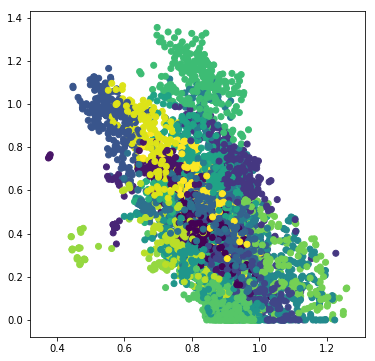

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(nmf[:, 0], nmf[:, 1], c=kmeans.labels_)
plt.colorbar()
plt.savefig('result_nmf.pdf')
plt.show()

In [21]:
#from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3).fit_transform(x_train)
for k in [4,6,8,10,12,14,16,18,20]:
    kmeans = KMeans(k)
    kmeans.fit(tsne)

    print(
        k,
        metrics.silhouette_score(tsne, kmeans.labels_)
    )

4 0.2776602
6 0.30783612
8 0.3178291
10 0.33614695
12 0.34008643
14 0.34565803
16 0.3360966
18 0.34040096
20 0.34539932


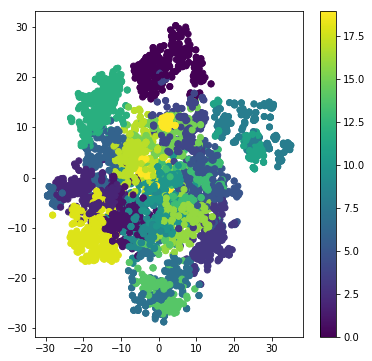

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans.labels_)
plt.colorbar()
plt.savefig('result_tsne.pdf')
plt.show()

In [23]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=5).fit_transform(x_train)
for k in [4,6,8,10,12,14,16,18,20]:
    clust = AgglomerativeClustering(k)
    clust.fit(ica)

    print(
        k,
        metrics.silhouette_score(ica, clust.labels_)
    )

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


4 0.2137812043191286
6 0.22618488195993192
8 0.21403504399620518
10 0.23598582138976473
12 0.24804904198236313
14 0.2429644680620988
16 0.24482216654501154
18 0.2518921872760587
20 0.23462101088579113


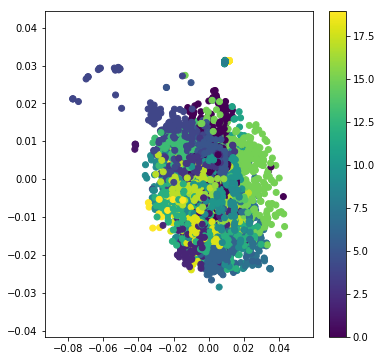

In [24]:
plt.figure(figsize=(6, 6))
plt.scatter(ica[:, 0], ica[:, 1], c=kmeans.labels_)
plt.colorbar()
plt.savefig('result_ica.pdf')
plt.show()

In [32]:
X = encoder.predict(x_train, batch_size=x_train.shape[0])

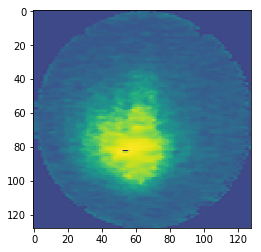

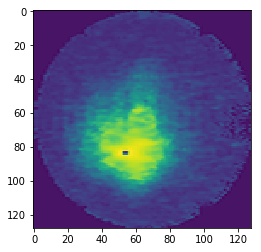

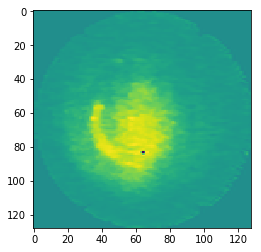

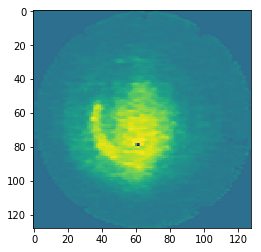

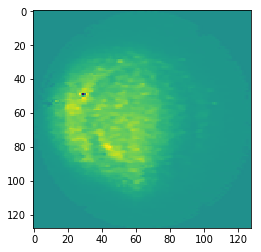

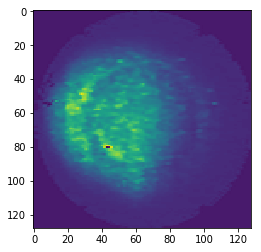

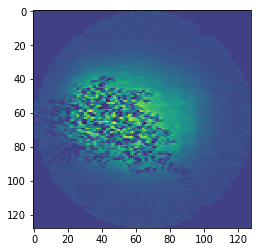

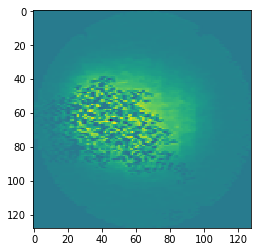

In [37]:
cat =  {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
for sample, label in zip(x_train[:100], kmeans.labels_[:100]):
    if label <= 5:
        sample = sample.reshape(128,128)
        cat[label].append(sample)

for sample in cat[0]:
    plt.imshow(sample)
    plt.show()

In [41]:
from sklearn.cluster import KMeans
from sklearn import metrics
from tqdm import tqdm_notebook

def count_score(clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
    return metrics.silhouette_score(X, kmeans.labels_)

for i in tqdm_notebook(range(5, 32)):
    score = count_score(i)
    print(i, score)

5 0.518992
6 0.4429144
7 0.44286042
8 0.42355564
9 0.41603035
10 0.41235492
11 0.42131174
12 0.41866806
13 0.40594676
14 0.40519673
15 0.3956682
16 0.40055144
17 0.39856562
18 0.38973746
19 0.39307103
20 0.38941252
21 0.39265153
22 0.3882131
23 0.3876313
24 0.38308042
25 0.38964579
26 0.3855734
27 0.38101718
28 0.38384178
29 0.38039795
30 0.38266
31 0.3806231



In [44]:
import pyclust

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2).fit_transform(x_train)
for k in [4,6,8,10,12,14,16,18,20]:
    kmeans = AgglomerativeClustering(k)
    kmeans.fit(svd)

    print(
        k,
        metrics.silhouette_score(svd, kmeans.labels_)
    )

4 0.46937314
6 0.3780924
8 0.35114577
10 0.35284883
12 0.3568388
14 0.33763316
16 0.35089463
18 0.350652
20 0.34095976


In [47]:
from sklearn.decomposition import FastICA

features = TruncatedSVD(n_components=3).fit_transform(x_train)
for k in [4,6,8,10,12,14,16,18,20]:
    clusters = AgglomerativeClustering(k)
    clusters.fit(features)

    print(
        k,
        metrics.silhouette_score(svd, clusters.labels_)
    )

4 0.4582967
6 0.22803625
8 0.2059232
10 0.18099664
12 0.1704976
14 0.16342318
16 0.14343177
18 0.12897015
20 0.123810716


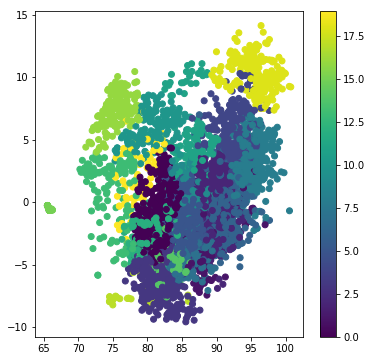

In [48]:
plt.figure(figsize=(6, 6))
plt.scatter(svd[:, 0], svd[:, 1], c=clusters.labels_)
plt.colorbar()
plt.show()

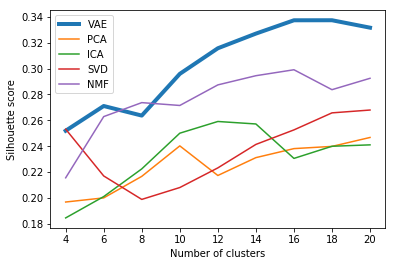

In [35]:
# Sample plot of the paper

import matplotlib.pyplot as plt
import numpy as np

clust = np.array([4, 6, 8, 10, 12, 14, 16, 18, 20])
vae = np.array([0.251977, 0.271088, 0.263687, 0.295925, 0.315701, 0.327036, 0.337328, 0.337356, 0.331617])
pca = np.array([0.196893, 0.200090, 0.216724, 0.240271, 0.217395, 0.231196, 0.238164, 0.239869, 0.246775])
ica = np.array([0.184608, 0.201103, 0.222500, 0.250083, 0.259127, 0.257206, 0.230595, 0.239978, 0.241063])
svd = np.array([0.253186, 0.217036, 0.198909, 0.208087, 0.223269, 0.241404, 0.252624, 0.265785, 0.267973])
nmf = np.array([0.215600, 0.262900, 0.273700, 0.271500, 0.287400, 0.294500, 0.299100, 0.283700, 0.292500])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(clust, vae, label="VAE", linewidth=4)
ax1.plot(clust, pca, label="PCA")
ax1.plot(clust, ica, label="ICA")
ax1.plot(clust, svd, label="SVD")
ax1.plot(clust, nmf, label="NMF")

ax1.legend(loc=2)


plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('agglomerative_5.pdf')
plt.show()